# Stable Diffusion for Digits
## By James Camacho

Papers that may be of interest:

- [Convolutional Neural Networks](https://arxiv.org/pdf/1511.08458.pdf)
- [Residual Connections](https://arxiv.org/pdf/1512.03385.pdf)
- [Variational Autoencoders](https://arxiv.org/pdf/1312.6114.pdf)
- [Recurrent Neural Networks](https://arxiv.org/pdf/1912.05911.pdf)
- [Gated Recurrent Units (GRU)](https://arxiv.org/pdf/2111.00396.pdf)
- [RNN Autoencoder](https://arxiv.org/pdf/1406.1078.pdf)
- [State-Space Models](https://arxiv.org/pdf/2111.00396.pdf)
- [RWKV](https://johanwind.github.io/2023/03/23/rwkv_details.html)
- [Attention (Transformers)](https://arxiv.org/pdf/1706.03762.pdf)
- [Scaling Laws](https://arxiv.org/pdf/2303.13506.pdf)
- [Power Seeking?](https://arxiv.org/pdf/1912.01683.pdf)
- [Photonic Matrix Multiplication](https://arxiv.org/pdf/2203.05466.pdf)
- [Photonic Neural Network](https://arxiv.org/pdf/2208.01623.pdf)

In [31]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

In [32]:
# Check if we have GPU

cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [35]:
%%capture output

# Download data and define image transformations (flatten + normalize)
# We split our data into train and test datasets. When the loss is small for
# the training data, we still want it to work with data it's never seen.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])



trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
testset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

In [36]:
class Encoder(nn.Module):
    """
    A convolutional encoder.

    For the MNIST dataset this will be:
    28 x 28 image ->
    16 x 10 x 10 representation ->
    32 x 4 x 4 representation ->
    hidden_size latent space.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.convolutions = nn.ModuleList([
            nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=3, padding=1),
        ])
        conv_size = 32 * ((input_size+8)//9)**2
        self.fc = nn.Linear(conv_size, hidden_size)
        
    def forward(self, x):
        for conv in self.convolutions:
            x = F.elu(conv(x))
        x = x.view(x.shape[0], -1)
        return torch.tanh(self.fc(x))

class Decoder(nn.Module):
    """
    The reverse process.
    """
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Linear(hidden_size, 32 * ((output_size+8)//9)**2)
        self.deconvolutions = nn.ModuleList([
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3, padding=1),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=3, padding=1),
        ])
        
    def forward(self, x):
        x = F.elu(self.fc(x))
        x = x.view(x.shape[0], 32, 4, 4)
        for deconv in self.deconvolutions:
            x = F.elu(deconv(x))
        return x

In [ ]:
def train_autoencoder(encoder, decoder, optim, epochs=10):
  encoder.train()
  decoder.train()

  for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
      if cuda_available:
        data = data.cuda()
      
      optim.zero_grad()

      output = decoder(encoder(data))
      loss = F.mse_loss(output, data)
      
      loss.backward()
      optim.step()

      total_loss += loss.item()
      if batch_idx % 1 == 0:
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), total_loss / (1 + batch_idx)))
        
def test_autoencoder(encoder, decoder):
  encoder.eval()
  decoder.eval()

  with torch.no_grad():
    total_loss = 0
    for (data, target) in test_loader:
      if cuda_available:
        data = data.cuda()
      
      output = decoder(encoder(data))
      loss = F.mse_loss(output, data)
      total_loss += loss.item()
  
  return total_loss / len(test_loader)

In [ ]:
encoder = Encoder(28, 32)
decoder = Decoder(32, 28)
if cuda_available:
  encoder = encoder.cuda()
  decoder = decoder.cuda()
# Train w/ Adam
optim = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))
train_autoencoder(encoder, decoder, optim, 10)
print(test_autoencoder(encoder, decoder))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

0.08348942399024964


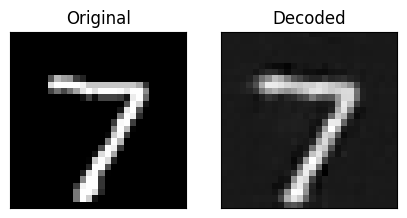

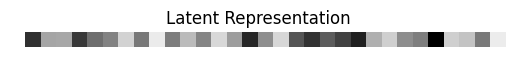

In [61]:
# Example encoding/decoding

x, y = testset[0]

fig, ax = plt.subplots(1, 2, figsize=(5, 10))
z = encoder(x.cuda().unsqueeze(0))
decoded = decoder(z).squeeze().squeeze().detach().cpu().numpy()

# Plot
ax[0].set_title("Original")
ax[1].set_title("Decoded")
ax[0].imshow(x[0], cmap="gray")
ax[1].imshow(decoded, cmap="gray")
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.show()

plt.title("Latent Representation")
plt.axis("off")
plt.imshow(z.detach().cpu().numpy(), cmap="gray")
plt.show();

In [56]:
class Diffuser(nn.Module):
    """
    Predicts the noise of the inputs.
    """
    def __init__(self, input_size, context_size, hidden_size):
        super().__init__()
        self.fc = nn.ModuleList([
            nn.Linear(input_size + context_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, input_size),
        ])
        
    def forward(self, x):
        x = F.elu(self.fc[0](x))
        for res in self.fc[1:-1]:
          x = x + F.elu(res(x)) # residual connections!
        return self.fc[-1](x)

In [ ]:
def train_diffuser(diffuser, encoder, optim, epochs=10):
  diffuser.train()
  encoder.eval()

  for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
      if cuda_available: data = data.cuda()
      with torch.no_grad():
        data = encoder(data)
      noise = torch.randn(data.size()) #* (1 + epoch) / epochs
      if cuda_available: noise = noise.cuda()
      data += noise

      # Add digit
      if np.random.rand() < 0.1:
        one_hot = F.one_hot(target, num_classes=10)
      else:
        one_hot = torch.zeros((*target.size(), 10))

      if cuda_available: one_hot = one_hot.cuda()
      
      data = torch.cat((data, one_hot), dim=-1)
      
      optim.zero_grad()
      output = diffuser(data)
      loss = F.mse_loss(output, noise)
      loss.backward()
      optim.step()

      total_loss += loss.item()
      if batch_idx % 1 == 0:
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), total_loss / (1 + batch_idx)))

In [ ]:
diffuser = Diffuser(32, 10, 128)
if cuda_available:
  diffuser = diffuser.cuda()

In [ ]:
optim = torch.optim.Adam(diffuser.parameters())
train_diffuser(diffuser, encoder, optim, 10)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

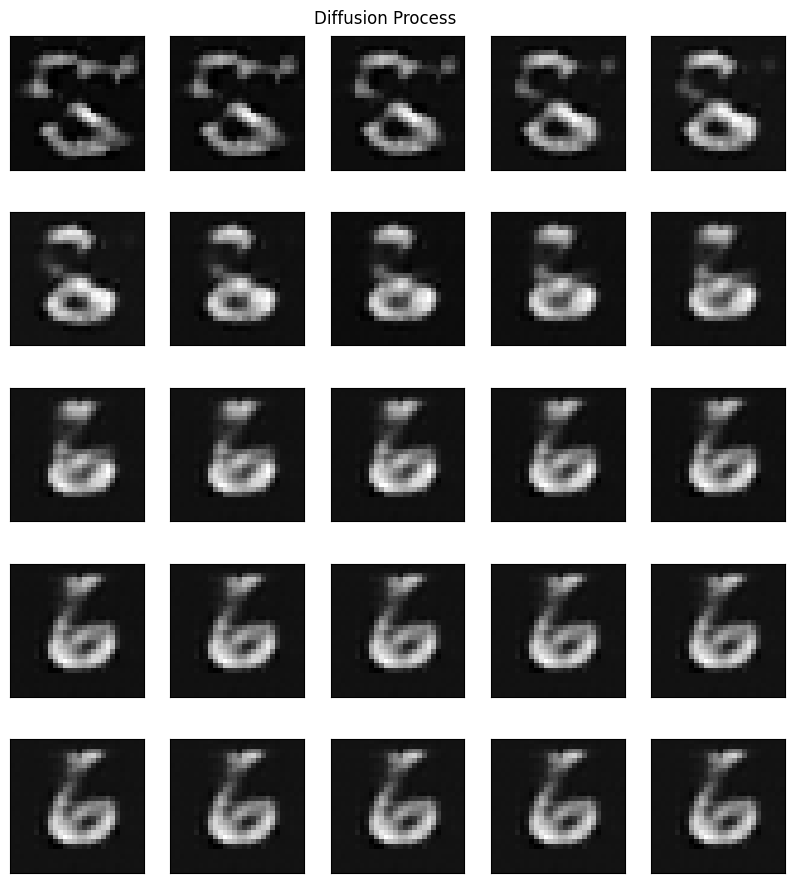

In [72]:
def to_img(latent):
  return decoder(latent).squeeze().squeeze().detach().cpu().numpy()

def generate(digit=None, steps=24, alpha=2e-1, beta=2):
  diffuser.eval()
  decoder.eval()
  
  if digit is None:
    digit = np.random.randint(10)
  with torch.no_grad():
    x = torch.randn(1, 32)
    zero_hot = torch.zeros((1, 10))
    one_hot = torch.clone(zero_hot)
    one_hot[0, digit] = 1
    if cuda_available:
      x = x.cuda()
      zero_hot = zero_hot.cuda()
      one_hot = one_hot.cuda()

    images = [torch.clone(x)]
    for i in range(steps):
      noise1 = diffuser(torch.cat((x, zero_hot), dim=-1))
      noise2 = diffuser(torch.cat((x, one_hot), dim=-1))
      x -= alpha * (beta * noise2 + (1-beta) * noise1)
      images.append(torch.clone(x))
  
  return images

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Diffusion Process")
fig.subplots_adjust(top=0.96)
for i, latent in enumerate(generate(6)):
  ax = axes[i//5, i%5]
  ax.imshow(to_img(latent), cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show();